In [ ]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
#     '''
#     DenseNet 121 Model for Keras

#     Model Schema is based on 
#     https://github.com/flyyufelix/DenseNet-Keras

#     # Returns
#         A Keras model instance.
#     '''

#     # Handle Dimension Ordering for different backends
#     global concat_axis
#     img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
#     concat_axis = 3


#     # From architecture for ImageNet (Table 1 in the paper)
#     nb_filter = 64
#     nb_layers = [6,12,24,16] # For DenseNet-121

#     # Initial convolution
#     x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(img_input)
#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Scale(axis=concat_axis)(x)
#     x = Activation('relu')(x)

#     x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#     # Add dense blocks
#     for block_idx in range(nb_dense_block - 1):
#         stage = block_idx+2
#         x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)

#         # Add transition_block
#         x = transition_block(x, stage, nb_filter, dropout_rate=dropout_rate)
#         nb_filter = int(nb_filter)

#     final_stage = stage + 1
#     x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Scale(axis=concat_axis )(x)
#     x = Activation('relu')(x)

#     x_fc = GlobalAveragePooling2D()(x)
#     x_fc = Dense(1000)(x_fc)
#     x_fc = Activation('softmax')(x_fc)

#     model = Model(img_input, x_fc)

#     # The method below works since pre-trained weights are stored in layers but not in the model
#     x_newfc = GlobalAveragePooling2D()(x)
#     x_newfc = Dense(num_classes)(x_newfc)
#     x_newfc = Activation('softmax')(x_newfc)

#     model = Model(img_input, x_newfc)

#     # Learning rate is changed to 0.001
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

In [ ]:
# def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
#     '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout '''


#     # 1x1 Convolution (Bottleneck layer)
#     inter_channel = nb_filter * 4  
#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Scale(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = Convolution2D(inter_channel, 1, 1, bias=False)(x)

#     if dropout_rate:
#         x = Dropout(dropout_rate)(x)

#     # 3x3 Convolution
#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Scale(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = ZeroPadding2D((1, 1))(x)
#     x = Convolution2D(nb_filter, 3, 3, bias=False)(x)

#     if dropout_rate:
#         x = Dropout(dropout_rate)(x)

#     return x


# def transition_block(x, stage, nb_filter, dropout_rate=None):
#     ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout  '''


#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Scale(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = Convolution2D(int(nb_filter), 1, 1, bias=False)(x)

#     if dropout_rate:
#         x = Dropout(dropout_rate)(x)

#     x = AveragePooling2D((2, 2), strides=(2, 2))(x)

#     return x


# def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, grow_nb_filters=True):
#     ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
#         # Arguments
#             x: input tensor
#             stage: index for dense block
#             nb_layers: the number of layers of conv_block to append to the model.
#             nb_filter: number of filters
#             growth_rate: growth rate
#             grow_nb_filters: flag to decide to allow number of filters to grow
#     '''

#     concat_feat = x

#     for i in range(nb_layers):
#         branch = i+1
#         x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
#         concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis)

#         if grow_nb_filters:
#             nb_filter += growth_rate

#     return concat_feat, nb_filter

In [ ]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(10,activation='softmax')(x)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("/content/drive/MyDrive/test/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("/content/drive/MyDrive/test/"+img)))
    for i in path:
        image = cv2.imread("/content/drive/MyDrive/test/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['horse', 'car', 'bird', 'ship', 'dog', 'frog', 'truck', 'cat', 'airplane', 'automobile']


In [ ]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 0 0 0 0 1 0 0]


In [ ]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(10,activation='softmax')(x) #FC-layer

In [ ]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(6006, 128, 128, 3) (4004, 128, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=40,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.97121, saving model to model.h5
46/46 - 57s - loss: 1.6731 - accuracy: 0.5182 - val_loss: 0.9712 - val_accuracy: 0.6672 - lr: 0.0010 - 57s/epoch - 1s/step
Epoch 2/40

Epoch 2: val_loss improved from 0.97121 to 0.79731, saving model to model.h5
46/46 - 30s - loss: 1.1507 - accuracy: 0.6347 - val_loss: 0.7973 - val_accuracy: 0.7424 - lr: 0.0010 - 30s/epoch - 650ms/step
Epoch 3/40

Epoch 3: val_loss improved from 0.79731 to 0.65734, saving model to model.h5
46/46 - 33s - loss: 1.0061 - accuracy: 0.6706 - val_loss: 0.6573 - val_accuracy: 0.7917 - lr: 0.0010 - 33s/epoch - 727ms/step
Epoch 4/40

Epoch 4: val_loss improved from 0.65734 to 0.58714, saving model to model.h5
46/46 - 32s - loss: 0.9251 - accuracy: 0.6871 - val_loss: 0.5871 - val_accuracy: 0.8080 - lr: 0.0010 - 32s/epoch - 698ms/step
Epoch 5/40

Epoch 5: val_loss improved from 0.58714 to 0.53687, saving model to model.h5
46/46 - 29s - loss: 0.8722 - accuracy: 0.7033 - val_loss: 

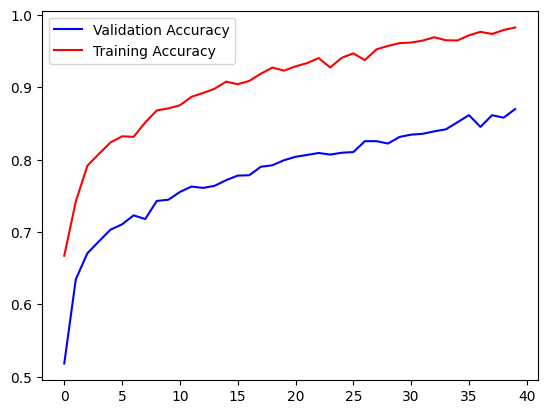

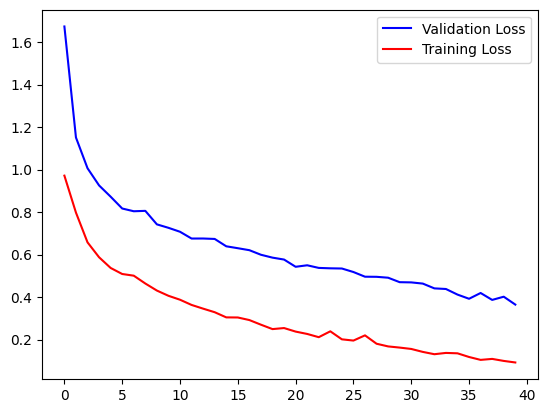

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Validation Accuracy')
plt.plot(epochs,val_acc,'r',label='Training Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Validation Loss')
plt.plot(epochs,val_loss,'r',label='Training Loss')
plt.legend()
plt.show()

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

126/126 [==============================] - 5s 43ms/step
Total-test-data; 4004 	accurately-predicted-data: 3114 	 wrongly-predicted-data:  890
Accuracy: 77.772 %


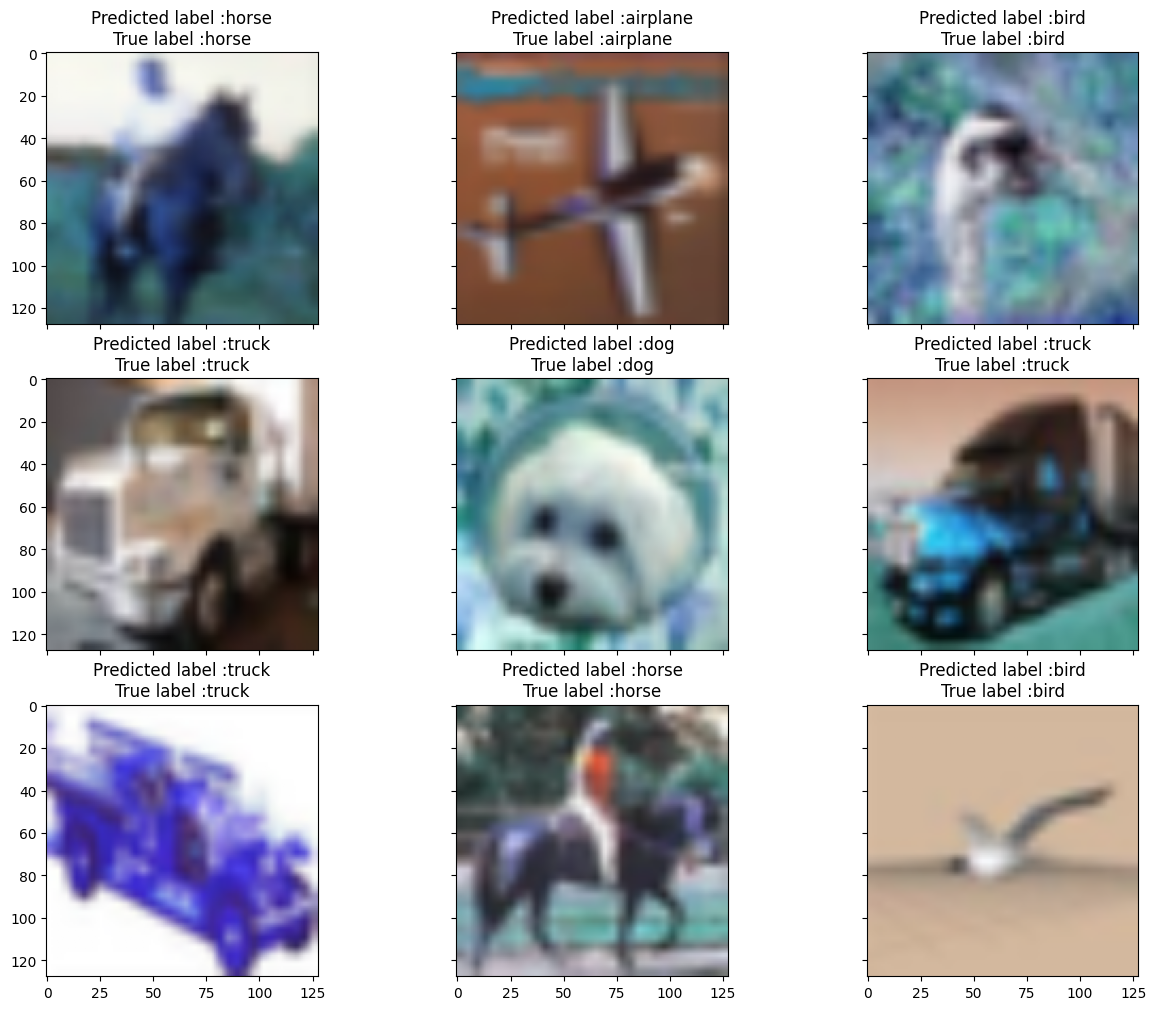

In [ ]:
label=['airplane', 'truck', 'bird', 'cat', 'ship', 'dog', 'car', 'deer', 'horse', 'frog']

imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 192.72222222222217, 'Predicted')

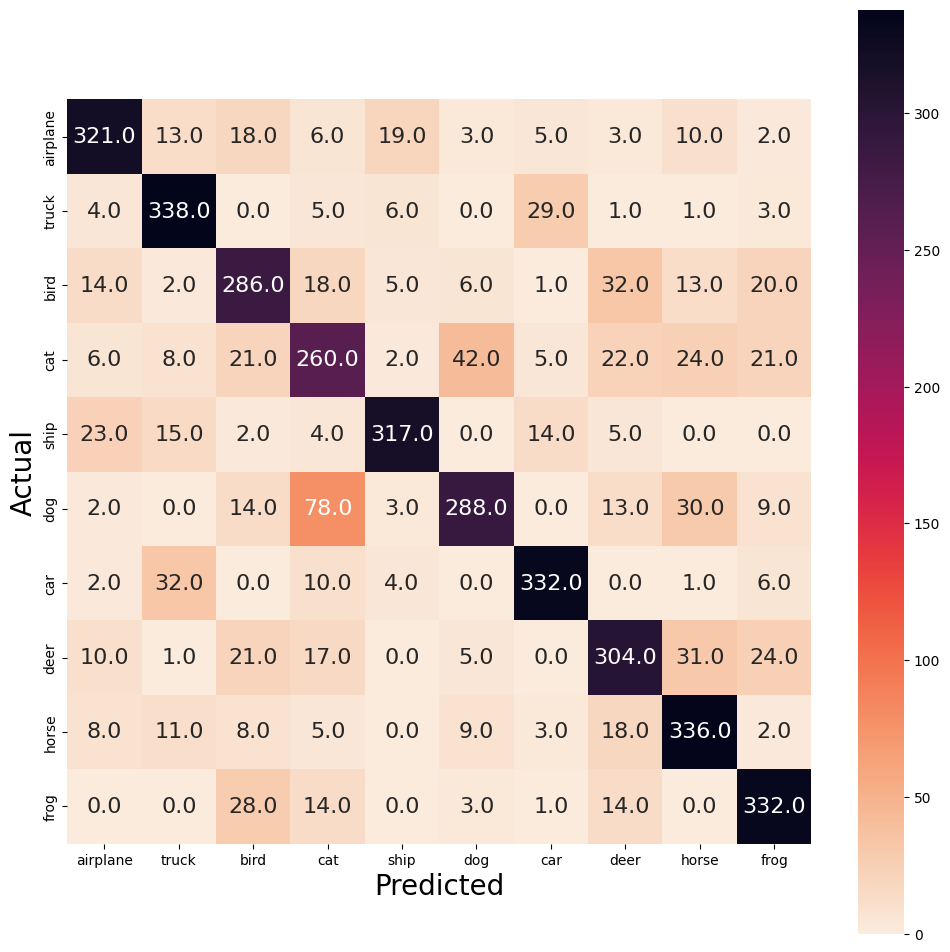

In [ ]:


Ypred = np.argmax(ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)